In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import skimage.draw as sk
import torch
from fastai.vision.all import *
from fastai.imports import *

print("Torch version:",torch.__version__)
print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.1.1
Is CUDA enabled? True


# Read data and create DataFrames
The dataset contains a lot of auxillary tabular data. In the ForestNet paper (https://stanfordmlgroup.github.io/projects/forestnet/) the tabular data imporved model performance when using Random Forest regression.  
However, the improvement was minimal when combined with UNet and ResNet architecture, which is why I have opted to drop it entriely in order to reduce time spent and complexity.   
I keep the merged_labels and the example_path from the csv-files.

In [24]:
train = pd.read_csv('../input/forestnet/ForestNetDataset/train_plantation.csv')
val = pd.read_csv('../input/forestnet/ForestNetDataset/val_plantation.csv')

In [25]:
train.drop(columns = ['merged_label','latitude','longitude','year'], inplace = True)
val.drop(columns = ['merged_label','latitude','longitude','year'], inplace = True)
train['is_valid'] = False
val['is_valid'] = True
imgset = pd.concat([train,val],ignore_index = True)
imgset.head()

label  \
0              Timber plantation   
1  Other large-scale plantations   
2              Timber plantation   
3              Timber plantation   
4            Oil palm plantation   

                                      example_path  is_valid  
0      examples/4.430849118860583_96.1016343478138     False  
1    examples/-2.100800102991412_113.0223763234016     False  
2   examples/-0.6522445100247509_109.9206187702712     False  
3   examples/-2.006610263824605_111.74631577940966     False  
4  examples/-1.3478682873694396_110.52786683455288     False

create dictionary with our labels and their corresponding pixel value

In [26]:
codes_dict = {'Undefined': 0, 'Other large-scale plantations': 1, 'Timber plantation': 2, 'Oil palm plantation': 3}
codes_dict.values()

dict_values([0, 1, 2, 3])

# Semantic segmentation data prep
each pixel inside the forest loss region is linked to a single class. This means that everything outside the forest loss region is undefined, and the result is a binary masks with labeled pixels inside the forest loss region and undefined pixels outside. In reality several deforestation drivers (labels) can be present in the same image, which is why my approach is to do per pixel segmentation on the entire image.  

The Forest loss regions are stored as pickle files and consists of MultiPolygons or single Polygons. As far as I know this datatype cannot be used in deep learning models so they have to be converted to PILMasks.
1. Iterate the Polygons and get their exterior coordinates  
2. Fill the outlines using the polygon2mask function https://scikit-image.org/docs/dev/api/skimage.draw.html#skimage.draw.polygon2mask
3. Map the mask(s) onto a zero initialized array with the correct resolution (in this case 332 x 332 pixels) using np.logical_or https://numpy.org/doc/stable/reference/generated/numpy.logical_or.html. This leaves us with a binary mask where ones are the forest loss region and zeroes are undefined.
4. Fill the values inside the forest loss region with the appropriate pixel value from our codes dictionary (1 for Plantation etc).  



In [27]:
def getEdges(polygon):
    edge = []
    for i in polygon.exterior.coords:
        x,y = i
        x = np.round(x).astype(int)
        y = np.round(y).astype(int)
        edge.append((x,y))
    return edge

In [28]:
def labelToInt(label,codes):
    for j,i in enumerate(codes):
        if (i == label):
            return j

In [29]:
def createPILMask(poly,label,codes):
    mask = np.zeros((332,332))
    edge = []
    if (poly.geom_type == 'Polygon'):
        edge = getEdges(poly)
        pmask = sk.polygon2mask((332,332),edge)
        mask = np.logical_or(mask,pmask)
    else:
        for polygon in poly.geoms:
            edge = getEdges(polygon)
            pmask = sk.polygon2mask((332,332),edge)
            mask = np.logical_or(mask,pmask)
    mask = np.uint8(mask)
    mask = mask * labelToInt(label,codes)
    mask = np.rot90(mask,1)
    return PILMask.create(mask)

In [30]:
def getForestLoss(path):
    with open('../input/forestnet/ForestNetDataset/'+ path +'/forest_loss_region.pkl', 'rb') as f:
        return pickle.load(f)

# Find suitable weights for the labels
The labels are unevenly represented in the dataset.   
An intuitive approach would be to normalize the distribution and pass them as weights to the loss function in order to counter the imbalance of occurences in the dataset.  
This is the approach I went for although I suspect it is far from optimal. I would have liked to explore this step further as the weights greatly influence the performance of the model.

In [31]:
train_count = train.label.value_counts()
train_count

label
Oil palm plantation              277
Timber plantation                193
Other large-scale plantations     92
Name: count, dtype: int64

In [32]:
val_count = val.label.value_counts()
val_count

label
Oil palm plantation              95
Timber plantation                60
Other large-scale plantations    20
Name: count, dtype: int64

In [33]:
norm_train = np.linalg.norm(np.array(train_count.values))
norm_val = np.linalg.norm(np.array(val_count.values))

In [34]:
n_1 = ((train_count / norm_train).values)
n_2 = ((val_count / norm_val).values)
weights = (n_1 + n_2) / 2
# Assign a weight of zero to the "Undefined" label.
weights = np.insert(weights[::-1],0,0.0)
print(codes_dict.keys())
weights

dict_keys(['Undefined', 'Other large-scale plantations', 'Timber plantation', 'Oil palm plantation'])


array([0.        , 0.21908129, 0.53864435, 0.81201055])

# Put the data in a DataBlock
since I created a is_valid column in my dataframe I can use the built in ColSplitter() to parse the training and validation data.  
Like in the paper I resize all images to 160x160 and randomly crop during training and center crop during prediction on validation/test.  
Ideally I would have experimented more with data augmentations but I ran out of GPU Quota. The variations I tried such as Dihedral, flips and zoom yielded no significant performance improvement.

In [67]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes = codes_dict)),
        splitter = ColSplitter(),
        get_x = lambda x: "../input/forestnet/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png",
        get_y = lambda x: createPILMask(getForestLoss(x[1]),x[0],codes_dict),
        item_tfms=Resize(160,method = 'crop'),
        batch_tfms=[Normalize.from_stats(*imagenet_stats)])


C:\Users\flori\AppData\Local\Temp\ipykernel_2472\667612848.py:3: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  return pickle.load(f)


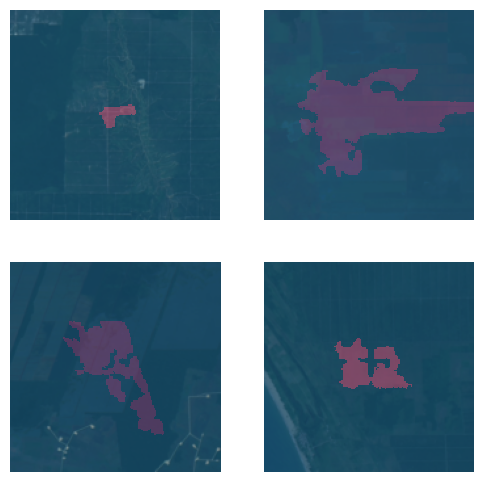

In [68]:
dls = db.dataloaders(imgset, bs = 4)
dls.show_batch(vmin = 0,vmax = 5)

# metrics
from https://github.com/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/04_Segmentation.ipynb  
I ignore the "Undefined" label when calculating pixel accuracy.

In [69]:
def accuracy(inp, targ):
    targ = targ.squeeze(1)
#   skip "Undefined"
    mask = targ != 0
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Learner and training
I initially used standard CrossEntropyLossFlat, but the LabelSmoothing-version yielded noticeable better results so I swapped. I suspect it is because the predicted probability values are pretty low for all labels.

In [70]:
learn = unet_learner(dls,
                     resnet34,
                     metrics = accuracy,
                     loss_func = LabelSmoothingCrossEntropyFlat(axis = 1,
                         weight = tensor(weights).cuda()))
learn.loss_func

C:\Users\flori\AppData\Local\Temp\ipykernel_2472\667612848.py:3: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  return pickle.load(f)


FlattenedLoss of LabelSmoothingCrossEntropy()

In [71]:
learn.fine_tune(8)

# Validation accuracy
I do per pixel segmentation on the entire image. However, I am only interested in the forest loss region. I solve this by going through these steps    
1. UNet gives a probability map for each label (in this case output shape is 5x160x160 per prediction), so in order to compose a segmented image I take the maximum probability value for each pixel with argmax (now i have a 160x160 mask).
2. look at the pixel values inside the forest loss region .
3. The pixel with the most occurences is the predicted label (so if 60% of the pixels are 2, the predicted label is "Smallholder agriculture" etc).

In [72]:
preds = learn.get_preds()
preds[0].shape

torch.Size([175, 4, 160, 160])

In [73]:
def label_predict(target,pred,codes,test):
    maskindices = np.nonzero(target)
    if test:
        maskindices = zip(maskindices[0],maskindices[1])
    pred_labels = pred.argmax(dim = 0)
    label_vals = [pred_labels[i[0]][i[1]].item() for i in maskindices]
    return list(codes)[scipy.stats.mode(label_vals, keepdims = True)[0][0]]

In [74]:
def accuracy(preds,df,codes):
    acc = {}
    undefined_count = 0
    for label in df.label.value_counts().index:
        label_indices = df[df.label == label].index
        acc[label] = [label_predict(preds[1][ind],preds[0][ind],codes_dict,False) for ind in label_indices]
    for key in acc.keys():
        vals = acc[key]
#         undefined_count += len([x for x in vals if "Undefined" in x])
        acc[key] = len([x for x in vals if key in x]) / len(vals)
#     print('undefined', undefined_count)
    return acc

In [75]:
vset = imgset[imgset.is_valid == True]
vset.reset_index(drop = True, inplace = True)
accuracy(preds,vset,codes_dict)

{'Oil palm plantation': 0.6631578947368421,
 'Timber plantation': 0.8166666666666667,
 'Other large-scale plantations': 0.3}

In [76]:
def predict_mask(target,pred,test):
    maskindices = np.nonzero(target)
    if test:
        maskindices = zip(maskindices[0],maskindices[1])
    pred_labels = pred.argmax(dim = 0)
    p_mask = np.zeros(target.shape)
    for i in maskindices:
        p_mask[i[0]][i[1]] = pred_labels[i[0]][i[1]].item()
    f, ax = plt.subplots(1,2,figsize=(20, 10))
    ax[0].imshow(target)
    ax[1].imshow(p_mask)
    ax[0].set_title("ground truth")
    ax[1].set_title("prediction")
    plt.show()

# Visualize predictions
I would have liked to include mapping of colors to labels here.

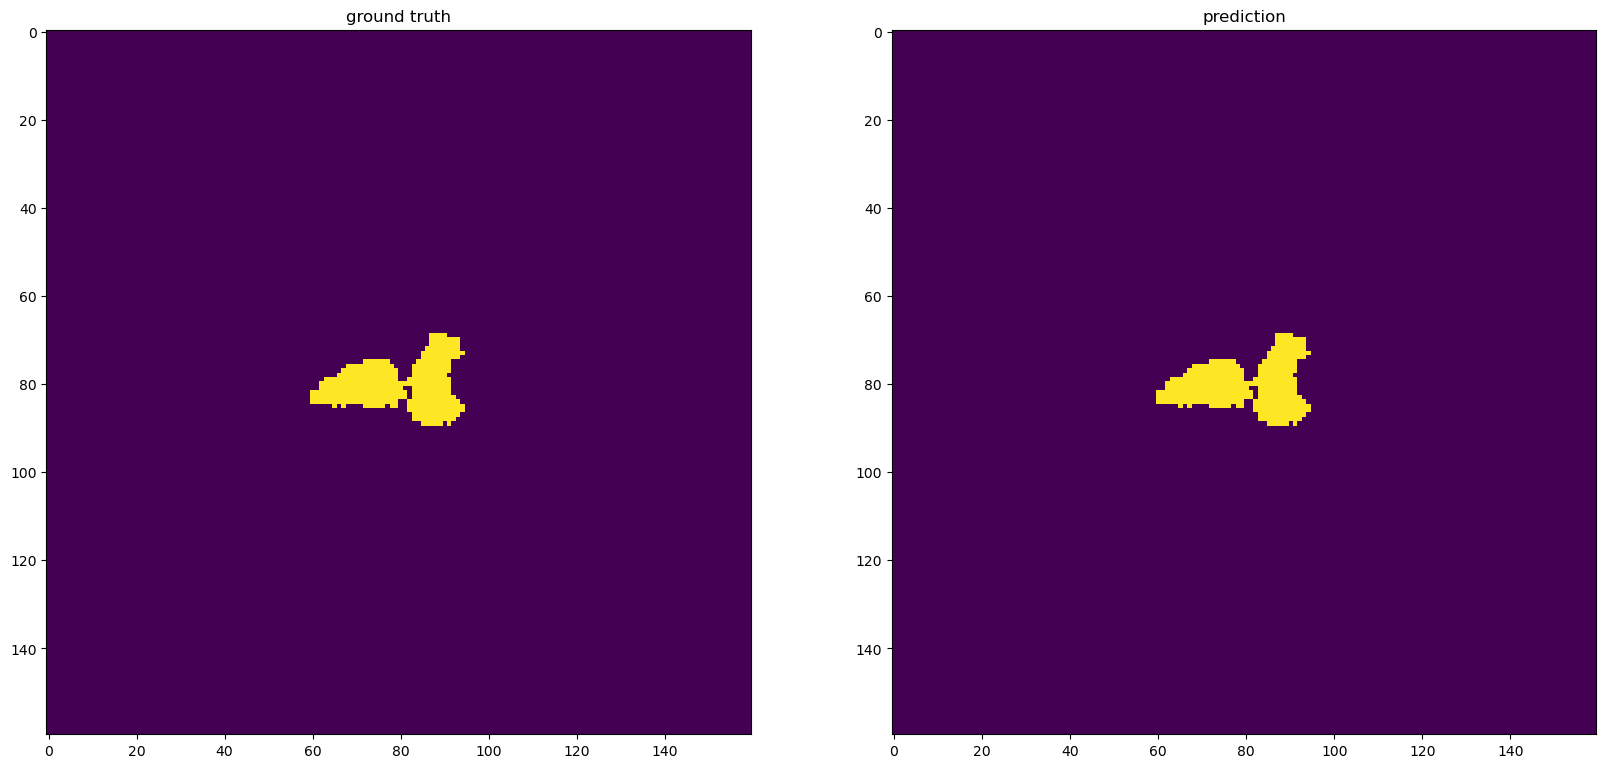

predicted label:  Oil palm plantation
correct label:  Oil palm plantation


In [77]:
picture = 43
predict_mask(preds[1][picture],preds[0][picture],False)
p = label_predict(preds[1][picture],preds[0][picture],codes_dict,False)
g = vset.iloc[picture][0]
print("predicted label: ", p)
print("correct label: ", g)

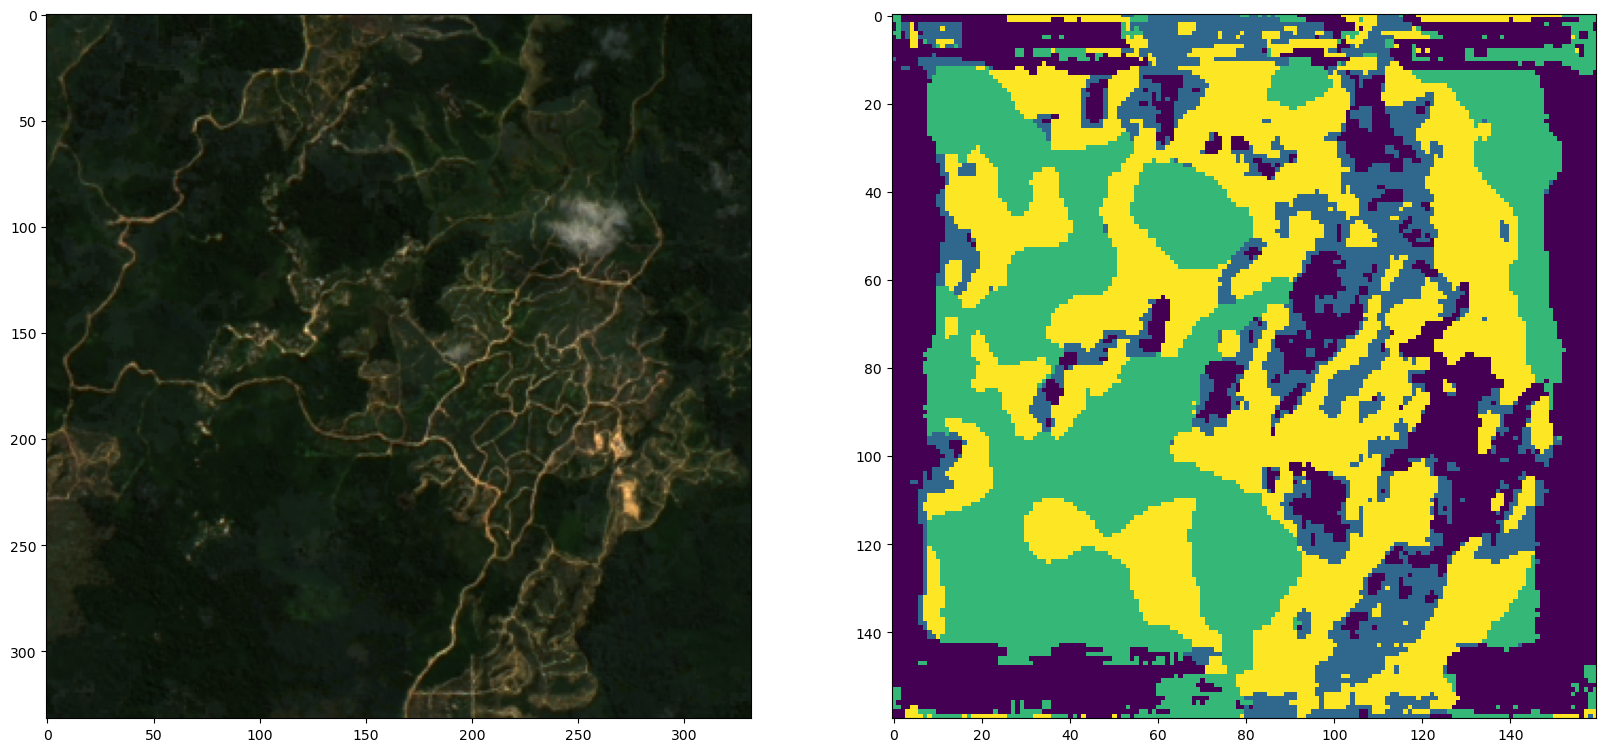

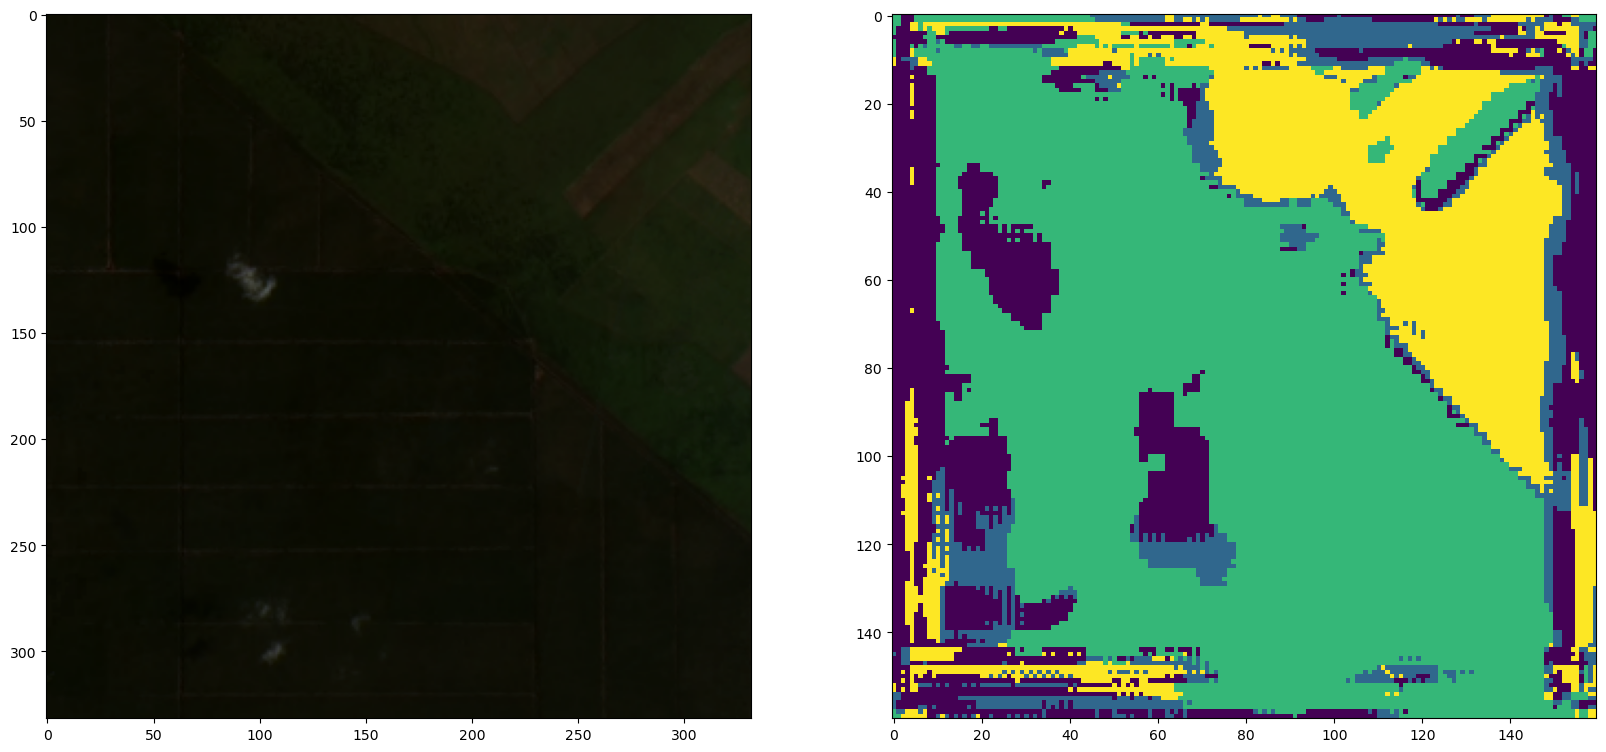

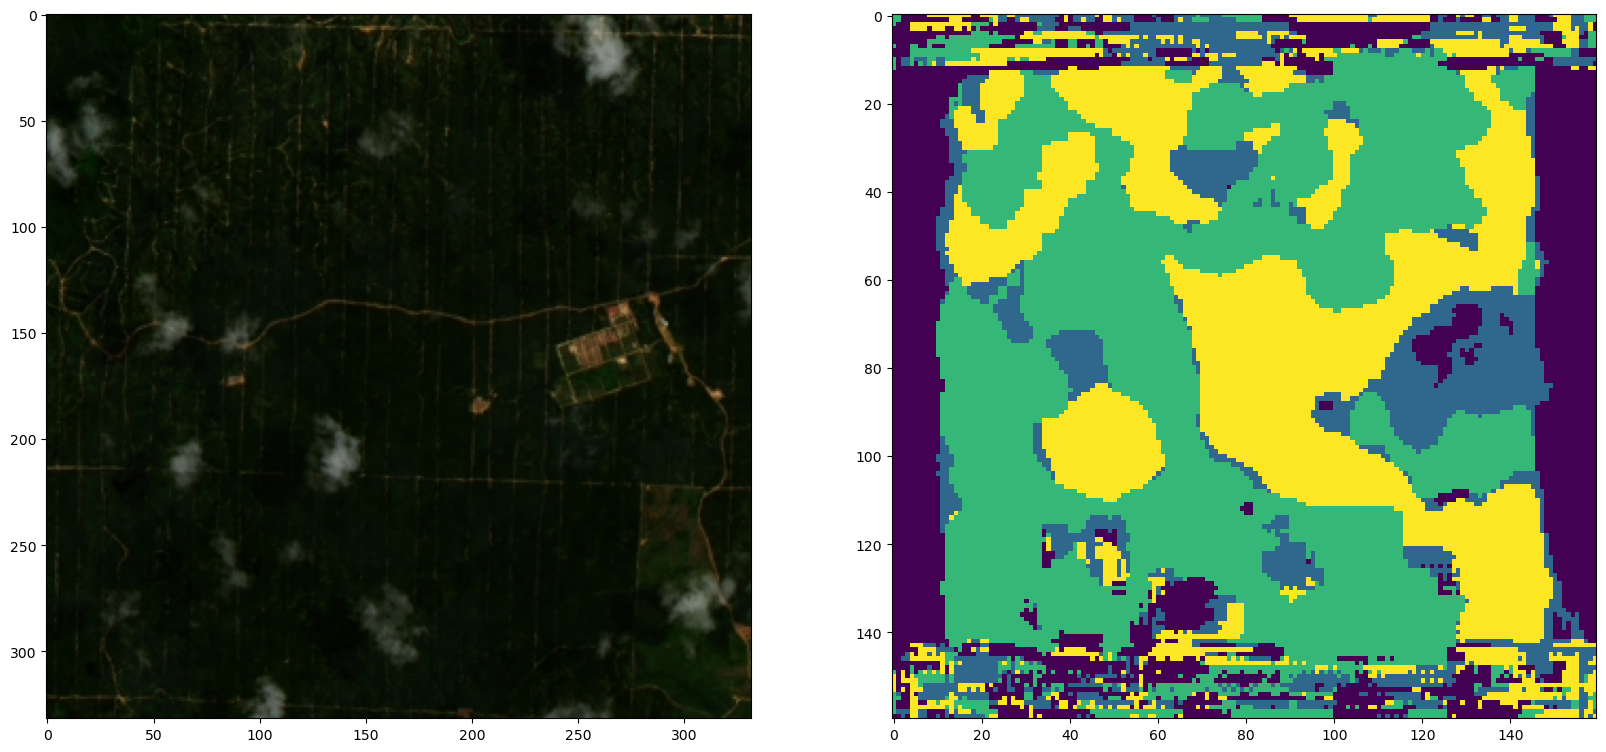

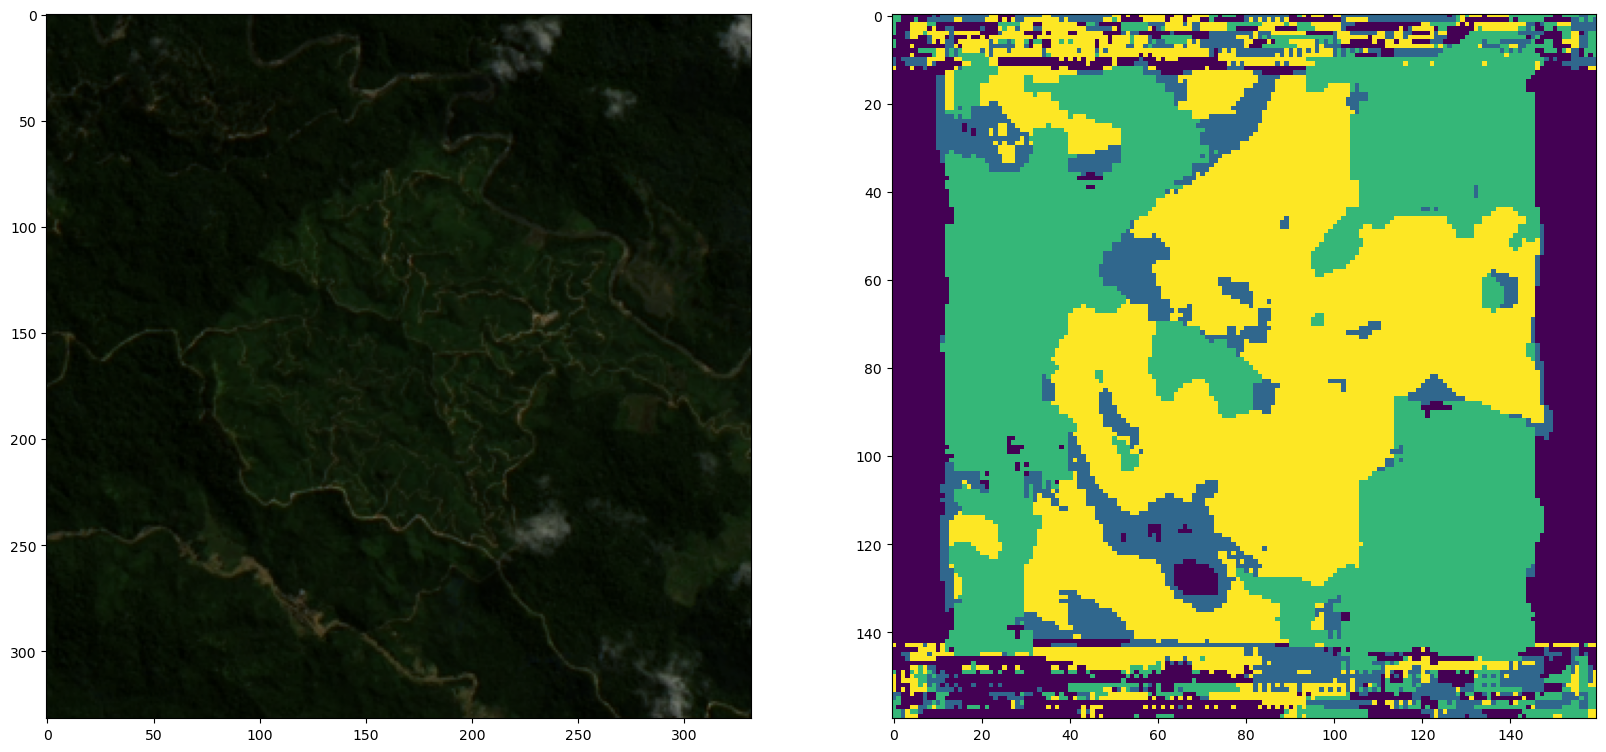

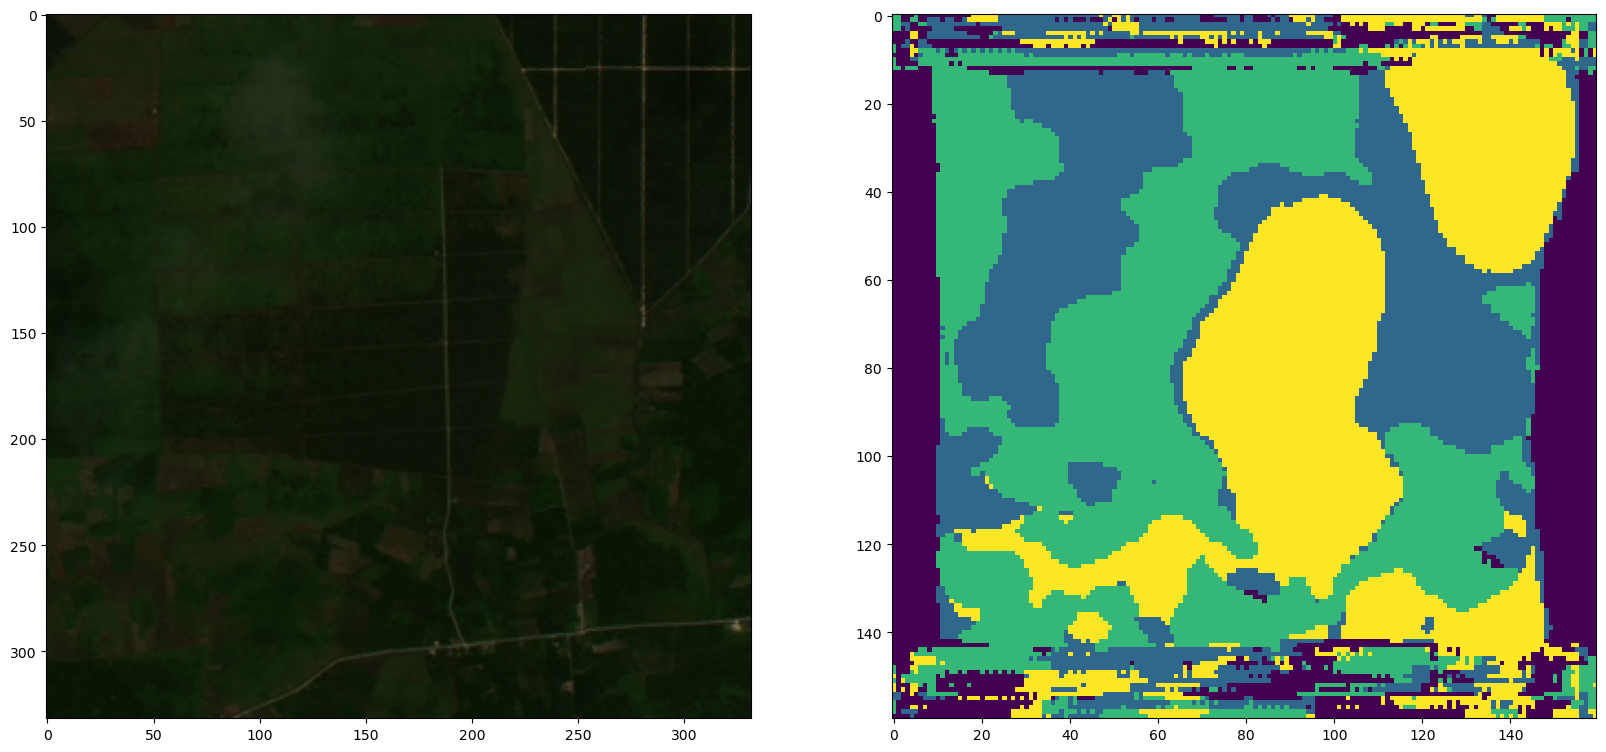

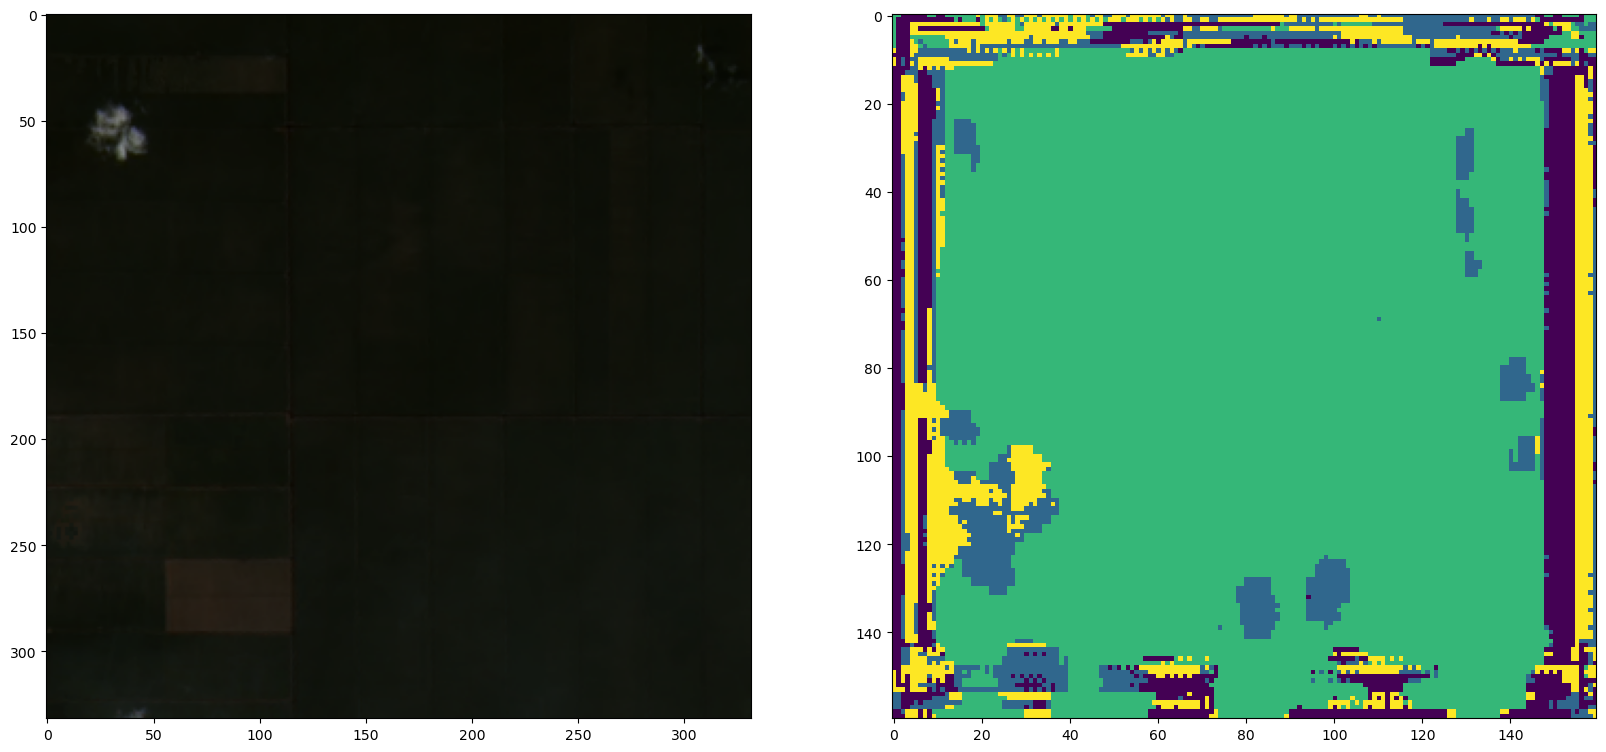

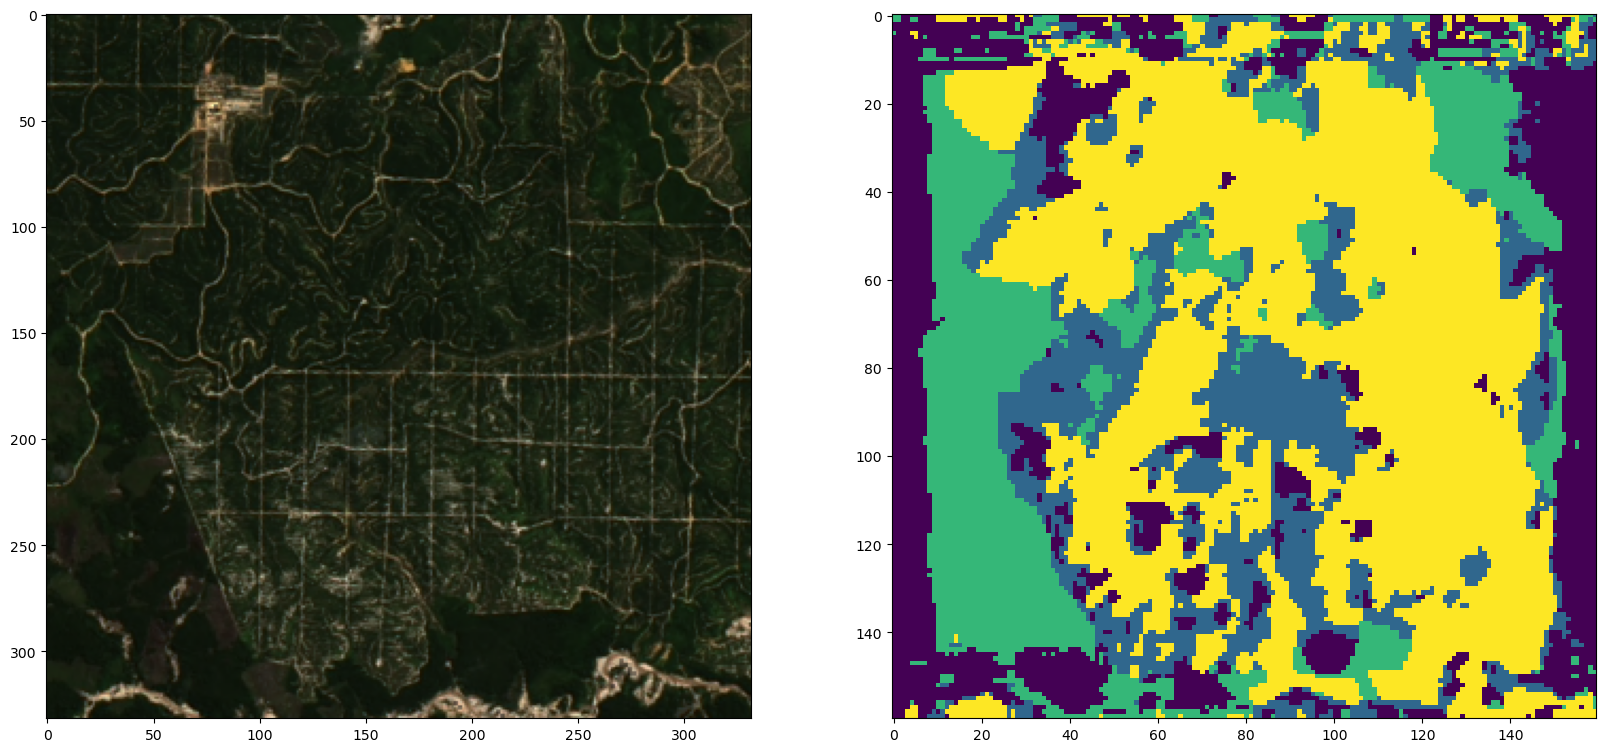

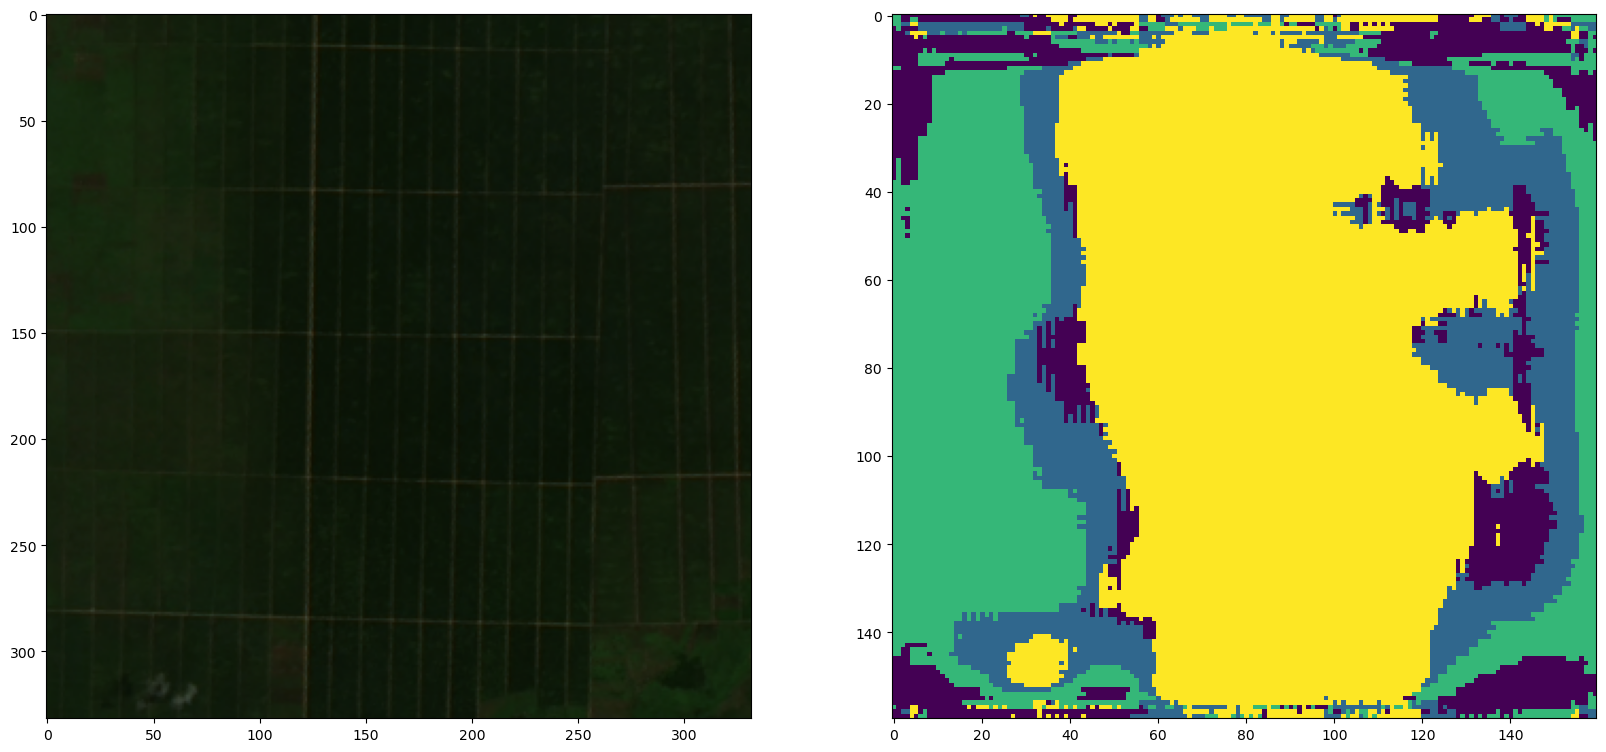

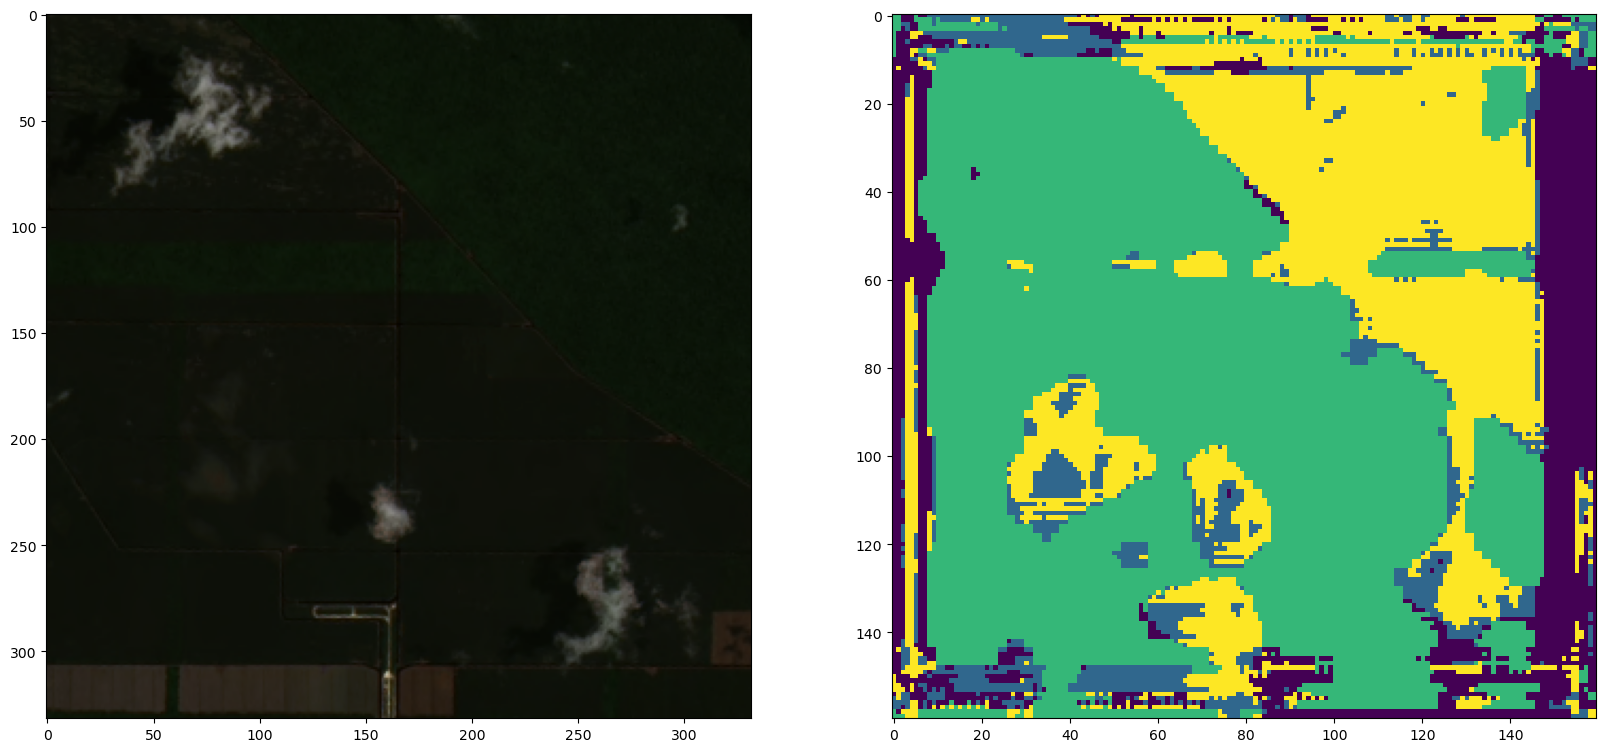

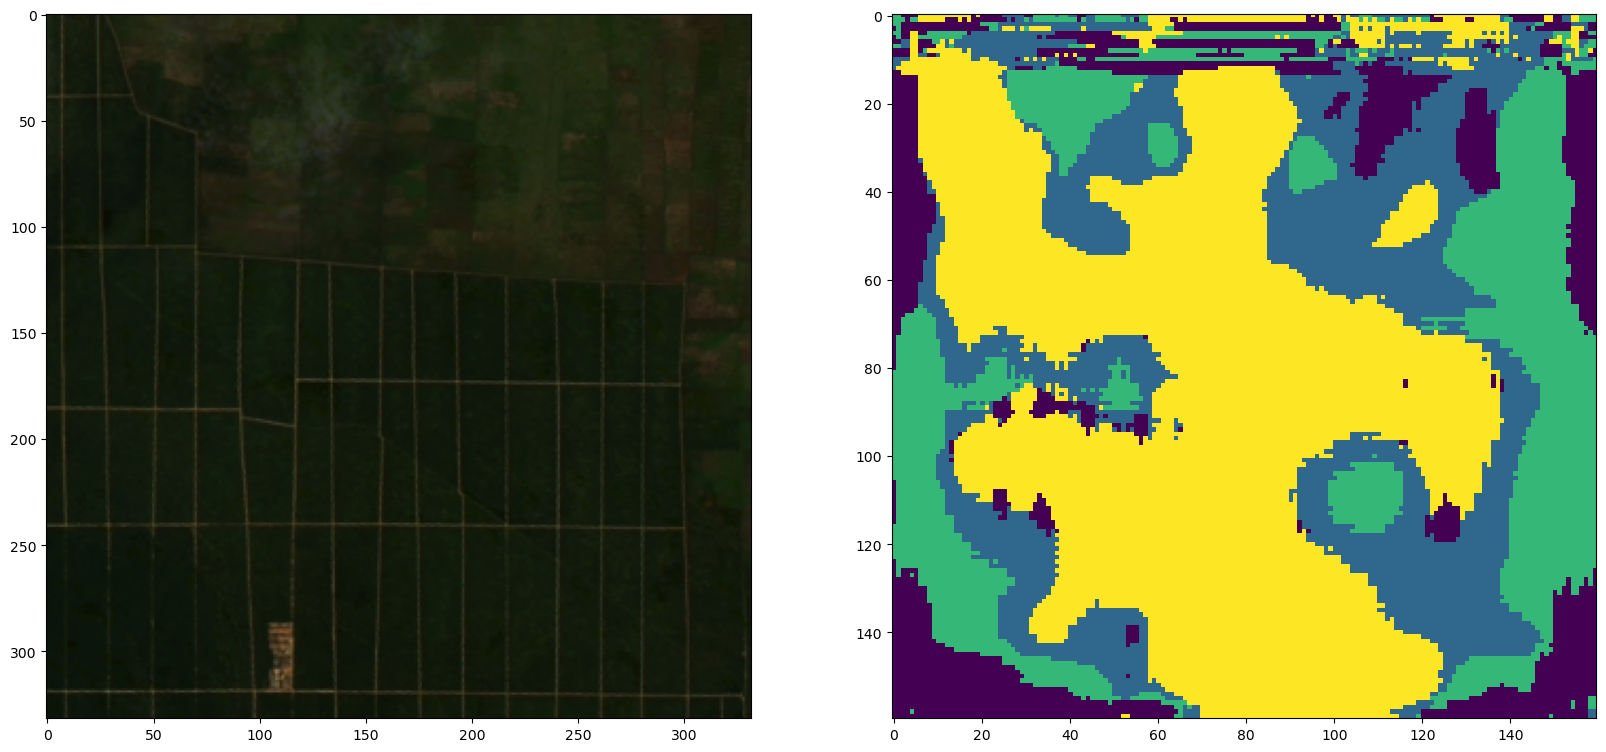

In [78]:
for i, j in enumerate(vset.head(10).values):
    f, ax = plt.subplots(1,2,figsize=(20, 10))
    im = PILImage.create("../input/forestnet/ForestNetDataset/"f'{j[1]}'"/images/visible/blended_images.png")
    ax[0].imshow(im)
    ax[1].imshow(preds[0][i].argmax(dim = 0))
    plt.show() 

# Examine model performance on test data
I use the composite images as input for the model on test data to ensure good quality of the input image. In the ForestNet paper the image captured temporally closest to the year of the forest loss event was primarily used as input.  

In [79]:
test = pd.read_csv('../input/forestnet/ForestNetDataset/test_new.csv')
test.drop(columns = ['merged_label','latitude','longitude','year'], inplace = True)

In [80]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [81]:
def t_acc(df,codes):
#     undefined_count = 0
    acc = []
    label = df.iloc[0][0]
    for x in df.values:
        im = PILImage.create("../input/forestnet/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png")
        AOI = createPILMask(getForestLoss(x[1]),x[0],codes)
        p = learn.predict(im)
        acc.append(label_predict(AOI.crop_pad(p[2].shape[1]),p[2],codes,True))
#     print(len([x for x in acc if "Undefined" in x]))
    return (len([x for x in acc if label in x]) / len(acc))

In [82]:
t_oilpalm = test[test.label == 'Oil palm plantation']
t_timber = test[test.label == 'Timber plantation']
t_otherplant = test[test.label == 'Other large-scale plantations']


oilpalm = t_acc(t_oilpalm,codes_dict)
timber = t_acc(t_timber,codes_dict)
otherplant = t_acc(t_otherplant,codes_dict)


In [83]:
print('oil palm accuracy: ', np.around(oilpalm,4))
print('timber accuracy: ', np.around(timber,4))
print('other large-scale accuracy: ', np.around(otherplant,4))

oil palm accuracy:  0.6727
timber accuracy:  0.6212
other large-scale accuracy:  0.1212
